## Learning to Rank Relevance Scores of Products and User Queries<br>Chakradhar Thota<br>DePaul university


### Abstract:

Learning to rank refers to machine learning techniques for training the model in a ranking task. Learning to rank is useful for many applications in Information Retrieval, Natural Language Processing, and Data Mining. In this project we have explored how an LETOR (Learning to Rank) is implemented on the Dataset having Categorical attributes which describes the Product Info and User queries to predict the Relevancy Scores. Query expansion is performed to expand the queries and Feature Engineering is implemented to extract the attributes required for the Regression Models.

In [1]:
import numpy as np
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
import copy
import operator
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn import decomposition
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [2]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

 ### Dataset Collection and Preprocessing
 
 In this project We have used Home Depot dataset provided in the Kaggle competition which comprises of Train, Test, Description and Attributes files. The Train dataset has the Information about the previous user search queries and its relevance score with respect to the results (Product titles). Test Data has the New set of queries and Product titles of which relevance score has to be determined. Finally, the Descriptions have the Information of detailed descriptions of all products in the store. Since Product title is the Precise short description, we may need the detailed explanation of the product in order to find the Relevance score with respect to the Query. So, the Descriptions were added to the Train and Test data by doing the Left Join and the Instances of the data with NaN values are replaced with empty strings.



In [3]:
home_depot_train=pd.read_csv("D:/train_new.csv",sep='\t',encoding="ISO-8859-1")
home_depot_desc=pd.read_csv("D:/product_descriptions_new.csv",sep='\t',encoding="ISO-8859-1")
home_depot_test = pd.read_csv("D:/test_new.csv",sep='\t',encoding="ISO-8859-1")
print("Dimsensions of Train data: {0}".format(home_depot_train.shape))
print("Dimsensions of Test data: {0}".format(home_depot_test.shape))

Dimsensions of Train data: (74067, 5)
Dimsensions of Test data: (112067, 4)


In [4]:
home_depot_train.head(5)

,id,product_uid,product_title,search_term,relevance
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67


In [5]:
home_depot_test.head(5)

,id,product_uid,product_title,search_term
0,4,100001,Simpson Strong-Tie 12-Gauge Angle,metal l brackets
1,5,100001,Simpson Strong-Tie 12-Gauge Angle,simpson sku able
2,6,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong ties
3,7,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong tie hcc668
4,10,100003,STERLING Ensemble 33-1/4 in. x 60 in. x 75-1/4...,bath and shower kit


#### Joining the Data with Product_Descriptions

In [6]:
home_depot_train=pd.merge(home_depot_train, home_depot_desc, on='product_uid', how = 'left')
home_depot_test=pd.merge(home_depot_test, home_depot_desc, on='product_uid', how = 'left')

#### Checking for NaN values

In [7]:
print("No.of Instances in Train data with NaN values with respect to each Attributes:")
print(home_depot_train.isna().sum())
print("No.of Instances in Test data with NaN values with respect to each Attributes:")
print(home_depot_test.isna().sum())


No.of Instances in Train data with NaN values with respect to each Attributes:
id                       0
product_uid              0
product_title            0
search_term              0
relevance                0
product_description    207
dtype: int64
No.of Instances in Test data with NaN values with respect to each Attributes:
id                       0
product_uid              0
product_title            0
search_term              0
product_description    319
dtype: int64


In [8]:
## Replacing the NaN values with the empty Strings
home_depot_train=home_depot_train.fillna("") 
home_depot_test=home_depot_test.fillna("")

print(" After Filling the NaN values No.of Instances in Train data with NaN values :")
print(home_depot_train.isna().sum())
print(" After Filling the NaN values No.of Instances in Test data with NaN values :")
print(home_depot_test.isna().sum())

 After Filling the NaN values No.of Instances in Train data with NaN values :
id                     0
product_uid            0
product_title          0
search_term            0
relevance              0
product_description    0
dtype: int64
 After Filling the NaN values No.of Instances in Test data with NaN values :
id                     0
product_uid            0
product_title          0
search_term            0
product_description    0
dtype: int64


### Methodology

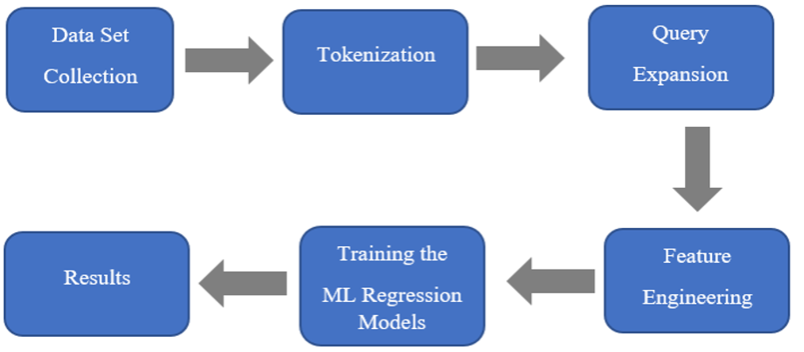

In [9]:
from IPython.display import Image
Image(filename='D:/Methodology.png', width=650)

### Tokenization
A function get_tokens_info is defined in the project to do the tokenization and Filtering the tokens. Along with this the function will compute the other characteristics of tokens like Tokens frequency configuration of each product, Term Frequencies which is the raw frequency of the token appearance in all products, Inverse Document Frequencies which is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus, Document length of each product and the Associations of each token with others in the corpus. These values are generated separately with respect to the Product titles and Description.

In [10]:
def get_tokens_info(Dataframe):
    
    unique_products={}          # Used to store the distinct product titles or descriptions as Keys 
                                # and the Tokens Configuration i.e. the Token Frequency in that respective document as Values.
    tokens_df={}                # Used to Calculate IDF values of Unique tokens which are Keys and its Document Frequency as values                    
    products_length={}          # This Dictionary has the Distinct product titles or Descriptions as Keys and its Document length as Values
    tokens_assoc={}             # This Dictionary has Unique Tokens as Keys and the value is another dictionary. 
                                #Together these which will describe the frequency of Co-occurance of two tokens. 
    
    tokens_tf = {}
    
    for product in Dataframe:   # DatFrame is either one of Product Titles or Product Description
        
        if product not in unique_products:         # Checking whether the Product title/ Description is already in the Unique_products.
                                                   # If not the New entry will be tokenized and the Info is stored in the Supposed Dictionaries.
            
            product_lower=product.strip().lower()
            product_tokens = word_tokenize(product_lower)                # Tokenizing the Content
            product_tokens = [w for w in product_tokens if w not in stopwords.words('english')] # Filtering English stopwords
            product_tokens = [w for w in product_tokens if w.isalpha()]
            porter = nltk.PorterStemmer()                                 # Porter stemmer object
            product_tokens = [porter.stem(tok) for tok in product_tokens] # apply stemmer
            distinct_tokens = dict(nltk.FreqDist(product_tokens))
            unique_products[product] = distinct_tokens                    # Distinct tokens are obtained and are stored in the Dict
            
            for token in distinct_tokens:                                
                if token not in tokens_df:           # Checking for the New Token and if it is new its will be Initialized to 0 
                    tokens_df[token]=0                            
                tokens_df[token]+=1                  # For every token in product Document frequency is incremented by 1.
                if token not in tokens_tf:
                    tokens_tf[token] = 0             #Token Frequency in the collection is updated
                tokens_tf[token]+=distinct_tokens[token]
                
                
                if token not in tokens_assoc:
                    tokens_assoc[token]={}
                tokens_list = tokens_assoc[token]   # For every Token in the Product its association with the other tokens is updated.
                for tok in distinct_tokens:
                    if tok!=token:
                        if tok not in tokens_list:
                            tokens_list[tok] = 0
                        tokens_list[tok] +=1
                
    tokens_idf = copy.deepcopy(tokens_df)
    for token in tokens_idf:
        tokens_idf[token] = np.log2(len(unique_products)/tokens_idf[token])     # Computing the IDF after obtaining the Document Frequencies of all Tokens
    
    for product in unique_products:
        product_tokens_list=unique_products[product]
        prod_length=0                                                       # Computing the Product Length with tokens TF_IDF values as Weights  
        for token in product_tokens_list:
            TF = product_tokens_list[token]
            IDF = tokens_idf[token]
            prod_length+=(TF*IDF)**2
        products_length[product]=prod_length
    
    return (unique_products, tokens_idf, products_length, tokens_assoc, tokens_tf)

In [11]:
### Obtaining the Tokens Info for both Product_titles and Product_descriptions
%time product_titles, titles_tokens_idf, titles_length, titles_tokens_assoc,titles_tokens_tf = get_tokens_info(home_depot_train.product_title)
%time product_desc, desc_tokens_idf, desc_length, desc_tokens_assoc,desc_tokens_tf = get_tokens_info(home_depot_train.product_description)

Wall time: 3min 33s
Wall time: 33min 19s


### Query Expansion
This is a process in Information Retrieval which consists of selecting and adding terms to user queries with the intention or goal to minimize query-document mismatch and thereby improving the retrieval performance. The following techniques are used for Query Expansion:

#### Through Mutual Information
Mutual information is one of many quantities that measures the mutual dependence of two random variables. The concept of mutual information is intricately linked to that of entropy of a random variable, a fundamental notion in information theory that quantifies the expected amount of information held in a random variable. Association of every token is computed during the Tokenization and based on the formula mentioned below the Mutual Information values are computed. For every token in the Query based on the Mutual Information the top two tokens with high values will be added to the Query.

In [12]:
def compute_mutual_info(tokens_assoc, tokens_termFreq):
    
    tokens_mutual_info = copy.deepcopy(tokens_assoc) ## Copying the Tokens_assoc into Tokens_mutual_info which will be later
                                                     ## used to store the Mutual Information values of two respective tokens.
    num_tokens  = 0
    
    for tok in tokens_termFreq:                     ## Computing Total #Tokens
        num_tokens += tokens_termFreq[tok]
    
    for token_X in tokens_assoc:
        
        tokens_list = tokens_assoc[token_X]
        F_X = tokens_termFreq[token_X]                ## Frequency of Token_X
        P_X = F_X/num_tokens                        ## Computing the Probability of Token_X
        
        for token_Y in tokens_list:
            F_Y = (tokens_termFreq[token_Y])        ## Frequency of Token_Y
            P_Y = F_Y/num_tokens                    ## Computing the Probability of Token_Y
            
            F_X_Y = tokens_list[token_Y]
            P_X_Y = F_X_Y/num_tokens
            tokens_mutual_info[token_X][token_Y] = np.log2(P_X_Y/ (P_X*P_Y)) ## Storing the Mutual Info Value
            
    return tokens_mutual_info

In [13]:
def expand_query_mutual(queries_list, tokens_mutual_info):
    
    expanded_queries_list = []
    
    for query in queries_list:
        
        query_lower = query.strip().lower()
        query_tokens = word_tokenize(query_lower)             ## Tokenizing the Queries
        query_tokens = [w for w in query_tokens if w not in stopwords.words('english')] # filter English stopwords
        query_tokens = [w for w in query_tokens if w.isalpha()]
        porter = nltk.PorterStemmer()                             # Porter stemmer object
        query_tokens = [porter.stem(tok) for tok in query_tokens] # apply stemmer
        
        for token in query_tokens:
            if token in tokens_mutual_info:
                sorted_tokens = sorted(tokens_mutual_info[token].items(),key=operator.itemgetter(1),reverse=True) ## Tokens are sorted in the Decreasing order of the Mutual Info values
                tokens_added = 0
                for i in range(len(sorted_tokens)):
                    if sorted_tokens[i][0] != token:               ## For every query token Top Two tokens having high Mutual Info will be added to the query.
                        query += (" "+sorted_tokens[i][0])
                        tokens_added += 1
                        if tokens_added == 2:
                            break
    
        expanded_queries_list.append(query)                     
    
    return (pd.Series(expanded_queries_list))                 ## The Expanded Queries are returned
            

In [14]:
### Computing the Mutual Info for Tokens in both Product_titles and Product_description

%time titles_tokens_mutual = compute_mutual_info(titles_tokens_assoc,titles_tokens_tf)
%time desc_tokens_mutual = compute_mutual_info(desc_tokens_assoc,desc_tokens_tf)

Wall time: 1.72 s
Wall time: 1min 24s


In [15]:
## Expanding the Queries with respect to both Title and Description tokens

%time exp_queries_mutual_titles = expand_query_mutual(home_depot_train.search_term, titles_tokens_mutual)
%time exp_queries_mutual_desc = expand_query_mutual(home_depot_train.search_term, desc_tokens_mutual)

Wall time: 2min 1s
Wall time: 16min 55s


#### Through WordNet
WordNet can be said as a superficial Thesaurus. WordNet is a lexical database in English which has Nouns Verbs Adjectives and Adverbs which are grouped in as cognitive synonyms also called Synsets. WordNet is different from all others by these features called relation that is WordNet structure is dependent on the words and its synonyms. By using WordNet for every word in the query the synonyms will be obtained out of which two synonym words will be added to the query.

In [16]:
def expand_query_wordnet(queries_list):
    
    expanded_queries_list = []
    
    for query in queries_list:
        
        query_words = query.lower().strip().split(" ")                ## Obtaining the words in the query
        
        for word in query_words:
            syns = wordnet.synsets(word)                              ## Getting the Synset of Words in query
            words_added = 0
            for i in range(len(syns)):
                synonym = (syns[i].lemmas()[0].name()).lower()       
                if synonym != word:                                 ## For every Word in the Query Two Synonyms which are distinct
                    query += (" "+synonym)                          ## withe the word are added ton the query
                    words_added += 1
                    if words_added == 2:
                        break
    
        expanded_queries_list.append(query)
    
    return (pd.Series(expanded_queries_list))

In [17]:
### Expanding the Queries using WordNet

%time exp_queries_wordnet = expand_query_wordnet(home_depot_train.search_term)

Wall time: 6.71 s


#### Through Correlation/Association Matrix
Association matrix are the matrices which quantify term correlations in terms of how frequently they co-occur. In this section a Document-Term matrix is created with rows as Product Titles and Columns as the distinct tokens/terms. An intermediate term-term association matrix can be created by multiplying the transpose of the above document-term matrix (which is a term-document matrix) by the document-term matrix, itself. This will result in a symmetric term-term matrix where each entry Cij corresponds to the dot product of the corresponding terms. For every token in the Query based on the Association/Correlation Matrix the top two tokens with high values will be added to the Query. This results in expanding queries with statistically most similar terms. Since 114425 unique tokens were generated for Product Descriptions it is not possible to Construct a Association Matrix as it results in getting Memory issues/Errors. So, Association Matrix is constructed only for tokens (12820) in the Product titles and the Query expansion is done with respect to the Titles.

In [18]:
def compute_corr_mat(products_list,tokens_list):
    
    DT = np.zeros((len(products_list),len(tokens_list)))  ### Doc_term matrix is created with products as Rows and Tokens as Columns 
                                                          ### All of the lements in the Doc_term matrix is initialized to 0.
    rows_names = list(products_list.keys())                              
    columns_names = list(tokens_list.keys())
    for product in products_list:
        row_index = rows_names.index(product)            ### For every Document/Product the Term frequency is updated for every token 
        product_terms = products_list[product]
        for term in product_terms:
            column_index = columns_names.index(term)
            DT[row_index,column_index] = product_terms[term]
        
    mat_1 = np.mat(DT.T)
    mat_2 = np.mat(DT)                                 ### The product of the Doc_Term and its transpose gives the Correlation matrix
    Corr_mat = np.matmul(mat_1, mat_2)
    
    Corr_mat_norm = np.zeros((Corr_mat.shape))
    
    for i in range(len(Corr_mat_norm)):
        for j in range(i+1):                          ### The Correlation Matrix is Normalized
            num = Corr_mat[i,j]
            denom = Corr_mat[i,i]+Corr_mat[j,j]-Corr_mat[i,j]
            Corr_mat_norm[i,j], Corr_mat_norm[j,i] = (num/denom), (num/denom)

    return pd.DataFrame(Corr_mat_norm, index = columns_names, columns = columns_names)
    

In [19]:
def expand_query_correlation(Corr_data, queries_list, tokens_list):
    
    expanded_queries_list = []
    
    for query in queries_list:
        
        query_lower = query.strip().lower()
        query_tokens = word_tokenize(query_lower)                          ## Tokenizing the Queries
        query_tokens = [w for w in query_tokens if w not in stopwords.words('english')] # filter English stopwords
        query_tokens = [w for w in query_tokens if w.isalpha()]
        porter = nltk.PorterStemmer()                             # Porter stemmer object
        query_tokens = [porter.stem(tok) for tok in query_tokens] # apply stemmer
        
        for token in query_tokens:
            if token in tokens_list:                      ## For Every Token the top two Tokens with hogh Correlation is added to the Query
                tokens_selected = ((Corr_data[token].sort_values(ascending=False)).index.tolist())[1:3]
                tokens_selected = ' '.join(tokens_selected)
                query += (" " + tokens_selected)         ## Selected tokens are added to the Query
        
        expanded_queries_list.append(query)
        
    return (pd.Series(expanded_queries_list))          

In [20]:
### Computing Correlation Matrix for the Product_titles
%time corr_mat = compute_corr_mat(product_titles,titles_tokens_idf)
%time exp_queries_corr = expand_query_correlation(corr_mat, home_depot_train.search_term,titles_tokens_idf)

Wall time: 7min 15s
Wall time: 13min 22s


### Feature Engineering
Feature engineering is about creating new input features from your existing ones so that the Machine Learning Algorithms will work. It is an important step as it helps us to extract some hidden information underlying the dataset by performing different operations. In this project using domain knowledge of the data Numerical features were created from the Text data create so that Regression model is trained to predict Relevance scores. Cosine, Jaccard, Dice, Dot product are the similarity measures computed to generate the features. Along with this Statistical features such as product length, query length, Common words ratio with respect to both query and Product is also computed. 

Even though the Similarity Features are statistically good enough to train the Regression Model, the reason for generating Statistical features is because as the Dot product is the numerator for every similarity measure the similarity values will be greater than zero only if Dot product > 0 indicating the strong correlation between them which will lead to Overfitting of the Model. Hence to overcome that problem Statistical Features are also generated.

In [21]:
def  get_sim_features(Dataframe,products_dict,tokens_dict,products_len_dict,query_state):
    
    Cosine_sim=[]
    dot_product=[]
    Dice_coeff=[]
    Jaccard_coeff=[]
    num_common_words=[]                   ### Empty Lists were created to store the Similarity and other Measures to generate Features
    common_words_ratio_query = []                    
    common_words_ratio_prod = []
    Doc_length_list = []
    query_length_list = []
    
    
    for row in Dataframe.iterrows():
        product = row[1][0]                    ### Product is retrieved from the Row
        if product in products_dict:           
            product_tokens = products_dict[product]        
            doc_length = products_len_dict[product]
            query = row[1][1]                          #### Query is retrieved from the Row
            query_lower = query.strip().lower()
            query_tokens = word_tokenize(query_lower)
            query_tokens = [w for w in query_tokens if w not in stopwords.words('english')] # filter English stopwords
            query_tokens = [w for w in query_tokens if w.isalpha()]
            porter = nltk.PorterStemmer()                             # Porter stemmer object
            query_tokens = [porter.stem(tok) for tok in query_tokens] # apply stemmer
            
            query_length=0
            dot_prod=0
            
            common_words=0
            for token in query_tokens:
                if token in tokens_dict:
                    idf = tokens_dict[token]
                    query_length += (idf)**2       ### Dot Product and Query Lengths are Caluculated by taking TF_IDF as weights
                    if token in product_tokens:
                        common_words += 1
                        tf = product_tokens[token]
                        dot_prod += (idf) * (tf*idf)
            
            Cosine_denom = np.sqrt((query_length)*(doc_length))
            Dice_denom = query_length + doc_length
            Jaccard_denom = (query_length + doc_length) - dot_prod          ### With the Query Document Lengths computations
            num_common_words.append(common_words)                           ### are done to calculate Dice, Jaccard, Cosine Denominators
            Doc_length_list.append(np.sqrt(doc_length))
            query_length_list.append(np.sqrt(query_length))
            
            if len(query_tokens) == 0:
                common_words_ratio_query.append(0)
            else:
                common_words_ratio_query.append(common_words/len(query_tokens))
                
            if len(product_tokens)==0:
                common_words_ratio_prod.append(0)                            
            else:
                common_words_ratio_prod.append(common_words/len(product_tokens))
                
            dot_product.append(dot_prod)
            
            if Dice_denom == 0:
                Dice_coeff.append(0)                            ### The Denominators of all Similarity measures are checked for Zero values 
            else:                                               ### If Denomiator is Zero then 0 will be appended to the list
                Dice_coeff.append((2*dot_prod)/Dice_denom)      ### Else the Similarity will be computed
            
            if Cosine_denom == 0:
                Cosine_sim.append(0)
            else:
                Cosine_sim.append(dot_prod/Cosine_denom)
                
            if Jaccard_denom == 0:
                Jaccard_coeff.append(0)
            else:
                Jaccard_coeff.append(dot_prod/Jaccard_denom)
                
        else:                                          ### For a product which is not in the Train data all of the Features willbe assigned to 0
            Dice_coeff.append(0)
            Cosine_sim.append(0)
            dot_product.append(0)
            num_common_words.append(0)
            Jaccard_coeff.append(0)
            common_words_ratio_prod.append(0)
            common_words_ratio_query.append(0)
            Doc_length_list.append(0)
            query_length_list.append(0)
            
            
    sim_features=pd.DataFrame({"Cosine_"+query_state:Cosine_sim,"Dice_"+query_state:Dice_coeff,"Dot product_"+query_state:dot_product,"Jaccard_"+query_state:Jaccard_coeff, "Product_length": Doc_length_list, "Query_length_"+query_state:query_length_list, "Common_words_ratio_query_"+query_state: common_words_ratio_query,"Common_words_ratio_product_"+query_state: common_words_ratio_prod})
    
    return sim_features

#### Features with Raw data

In [22]:
title_query_DF = home_depot_train[["product_title","search_term"]]
%time title_features = get_sim_features(title_query_DF, product_titles, titles_tokens_idf, titles_length,"Raw Queries")
desc_query_DF = home_depot_train[["product_description","search_term"]]
%time desc_features = get_sim_features(desc_query_DF, product_desc, desc_tokens_idf, desc_length,"Raw Queries")

Wall time: 1min 22s
Wall time: 1min 24s


#### Features with Mutual Information

In [23]:
Data = pd.DataFrame({"product_title":home_depot_train.product_title,"queries_expanded":exp_queries_mutual_titles})
%time title_features_mutual = get_sim_features(Data, product_titles, titles_tokens_idf, titles_length,"Mutual Info")
title_features_mutual = title_features_mutual.drop(["Product_length"],axis = 1)
Data = pd.DataFrame({"product_description":home_depot_train.product_description,"queries_expanded":exp_queries_mutual_desc}) 
%time desc_features_mutual = get_sim_features(Data, product_desc, desc_tokens_idf, desc_length,"Mutual Info")
desc_features_mutual = desc_features_mutual.drop(["Product_length"],axis = 1)

Wall time: 3min 15s
Wall time: 3min 11s


#### Features with WordNet Synonymns

In [24]:
Data = pd.DataFrame({"product_title":home_depot_train.product_title,"queries_expanded":exp_queries_wordnet})
%time title_features_WN = get_sim_features(Data, product_titles, titles_tokens_idf, titles_length,"Word Net")
title_features_WN = title_features_WN.drop(["Product_length"],axis = 1)
Data = pd.DataFrame({"product_description":home_depot_train.product_description,"queries_expanded":exp_queries_wordnet})
%time desc_features_WN = get_sim_features(Data, product_desc, desc_tokens_idf, desc_length,"Word Net")
desc_features_WN = desc_features_WN.drop(["Product_length"],axis = 1)

Wall time: 2min 29s
Wall time: 2min 46s


#### Features with Correlated Words

In [25]:
Data = pd.DataFrame({"product_title":home_depot_train.product_title,"queries_expanded":exp_queries_corr})
%time title_features_corr = get_sim_features(Data, product_titles, titles_tokens_idf, titles_length,"Correlated Words")
title_features_corr = title_features_corr.drop(["Product_length"],axis = 1)

Wall time: 3min 21s


### Features obtaining for Test Data

#### Features with Raw data

In [26]:
title_query_test = home_depot_test[["product_title","search_term"]]
%time title_features_test = get_sim_features(title_query_test, product_titles, titles_tokens_idf, titles_length,"Raw Queries")
desc_query_test = home_depot_test[["product_description","search_term"]]
%time desc_features_test = get_sim_features(desc_query_test, product_desc, desc_tokens_idf, desc_length,"Raw Queries")

Wall time: 1min 5s
Wall time: 1min 10s


#### Features with WordNet Synonymns

In [27]:
%time exp_queries_wordnet_test = expand_query_wordnet(home_depot_test.search_term)
Data = pd.DataFrame({"product_title":home_depot_test.product_title,"queries_expanded":exp_queries_wordnet_test})
%time title_features_WN_test = get_sim_features(Data, product_titles, titles_tokens_idf, titles_length,"Word Net")
title_features_WN_test = title_features_WN_test.drop(["Product_length"],axis = 1)
Data = pd.DataFrame({"product_description":home_depot_test.product_description,"queries_expanded":exp_queries_wordnet_test})
%time desc_features_WN_test = get_sim_features(Data, product_desc, desc_tokens_idf, desc_length,"Word Net")
desc_features_WN_test = desc_features_WN_test.drop(["Product_length"],axis = 1)

Wall time: 6.59 s
Wall time: 1min 48s
Wall time: 1min 57s


#### Features with Correlated Words

In [28]:
%time exp_queries_corr_test = expand_query_correlation(corr_mat, home_depot_test.search_term,titles_tokens_idf)
Data = pd.DataFrame({"product_title":home_depot_test.product_title,"queries_expanded":exp_queries_corr_test})
%time title_features_corr_test = get_sim_features(Data, product_titles, titles_tokens_idf, titles_length,"Correlated Words")
title_features_corr_test = title_features_corr_test.drop(["Product_length"],axis = 1)

Wall time: 21min 56s
Wall time: 2min 8s


#### Features with Mutual Information

In [29]:
%time queries_mutual_titles_test = expand_query_mutual(home_depot_test.search_term, titles_tokens_mutual)
%time queries_mutual_desc_test = expand_query_mutual(home_depot_test.search_term, desc_tokens_mutual)
Data = pd.DataFrame({"product_title":home_depot_test.product_title,"queries_expanded":queries_mutual_titles_test})
%time title_features_mutual_test = get_sim_features(Data, product_titles, titles_tokens_idf, titles_length,"Mutual Info")
title_features_mutual_test = title_features_mutual_test.drop(["Product_length"],axis = 1)
Data = pd.DataFrame({"product_description":home_depot_test.product_description,"queries_expanded":queries_mutual_desc_test}) 
%time desc_features_mutual_test = get_sim_features(Data, product_desc, desc_tokens_idf, desc_length,"Mutual Info")
desc_features_mutual_test = desc_features_mutual_test.drop(["Product_length"],axis = 1)

Wall time: 3min 32s
Wall time: 26min 39s
Wall time: 1min 51s
Wall time: 2min 2s


### Merging All Features generated at various Expansion steps

In [30]:
Full_data_train = pd.concat((title_features,desc_features,desc_features_WN,title_features_WN,title_features_mutual,desc_features_mutual,title_features_corr),axis=1)
Full_data_test = pd.concat((title_features_test,desc_features_test,desc_features_WN_test,title_features_WN_test,title_features_mutual_test,desc_features_mutual_test,title_features_corr_test),axis=1)

In [31]:
Full_data_train.to_csv("D:/Full_data_train.csv", float_format="%1.2f")
Full_data_test.to_csv("D:/Full_data_test.csv", float_format="%1.2f")

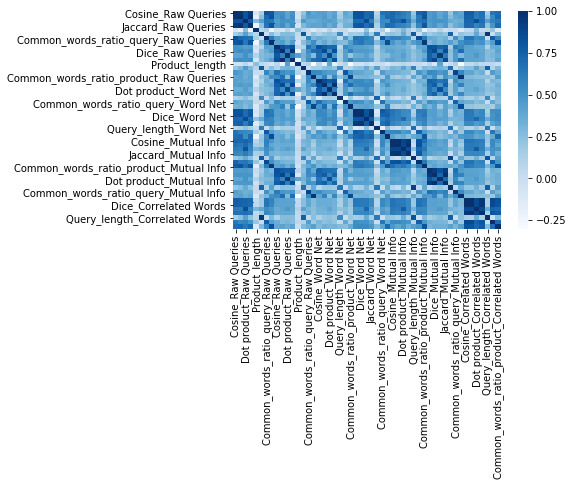

In [32]:
sns.heatmap(Full_data_train.corr(), cmap = "Blues")

In [33]:
Full_data_train.corr()

,Cosine_Raw Queries,Dice_Raw Queries,Dot product_Raw Queries,Jaccard_Raw Queries,Product_length,Query_length_Raw Queries,Common_words_ratio_query_Raw Queries,Common_words_ratio_product_Raw Queries,Cosine_Raw Queries,Dice_Raw Queries,...,Query_length_Mutual Info,Common_words_ratio_query_Mutual Info,Common_words_ratio_product_Mutual Info,Cosine_Correlated Words,Dice_Correlated Words,Dot product_Correlated Words,Jaccard_Correlated Words,Query_length_Correlated Words,Common_words_ratio_query_Correlated Words,Common_words_ratio_product_Correlated Words
Cosine_Raw Queries,1.000000,0.974640,0.825349,0.942404,-0.086071,0.143872,0.817998,0.798929,0.509860,0.512502,...,0.210369,0.445263,0.400489,0.772816,0.766438,0.626661,0.681324,0.154802,0.640527,0.692398
Dice_Raw Queries,0.974640,1.000000,0.817342,0.984025,-0.189418,0.248270,0.720310,0.831057,0.491788,0.539690,...,0.272933,0.390759,0.425879,0.749009,0.742061,0.615408,0.667921,0.253035,0.550416,0.717652
Dot product_Raw Queries,0.825349,0.817342,1.000000,0.782783,0.263023,0.431635,0.674943,0.646876,0.442568,0.508451,...,0.369693,0.340070,0.365277,0.731685,0.733238,0.845548,0.683347,0.424607,0.585300,0.631749
Jaccard_Raw Queries,0.942404,0.984025,0.782783,1.000000,-0.220974,0.236809,0.655490,0.817053,0.468235,0.530410,...,0.245627,0.359204,0.413593,0.718752,0.707856,0.585828,0.654223,0.237985,0.495492,0.702999
Product_length,-0.086071,-0.189418,0.263023,-0.220974,1.000000,0.082760,0.149430,-0.227641,-0.021286,-0.070367,...,0.044318,0.028511,-0.111197,0.038833,0.052156,0.302422,0.046495,0.079193,0.207628,-0.121262
Query_length_Raw Queries,0.143872,0.248270,0.431635,0.236809,0.082760,1.000000,0.001689,0.259115,0.106674,0.263331,...,0.740195,-0.010219,0.222996,0.178795,0.176970,0.384480,0.169448,0.963707,0.015505,0.272650
Common_words_ratio_query_Raw Queries,0.817998,0.720310,0.674943,0.655490,0.149430,0.001689,1.000000,0.635954,0.426705,0.352829,...,0.118149,0.513178,0.304325,0.657902,0.658863,0.532656,0.564759,0.013668,0.766898,0.555945
Common_words_ratio_product_Raw Queries,0.798929,0.831057,0.646876,0.817053,-0.227641,0.259115,0.635954,1.000000,0.417314,0.460084,...,0.426608,0.324802,0.520914,0.593517,0.576078,0.479646,0.511338,0.286747,0.445699,0.831985
Cosine_Raw Queries,0.509860,0.491788,0.442568,0.468235,-0.021286,0.106674,0.426705,0.417314,1.000000,0.852973,...,0.148783,0.628417,0.545479,0.423291,0.421104,0.365623,0.375473,0.125665,0.354428,0.382419
Dice_Raw Queries,0.512502,0.539690,0.508451,0.530410,-0.070367,0.263331,0.352829,0.460084,0.852973,1.000000,...,0.252266,0.490184,0.692925,0.420921,0.416392,0.409337,0.385050,0.266632,0.282511,0.416179


### Feature Extraction

From the above correlation matrix we can see that there is statistically significant correlation between the features. Due to this correlation the Prediction models will be overfitted to Training. So inorder to overcome this  problem we want to apply PCA where the Components will be orthogonal i.e. Uncorrelated. Since we want to include all variances like Shared variance, Error varaiance we are considering the components which can expalin 95% of the total variance.

In [34]:
scaler=StandardScaler()
Full_data_train_norm = scaler.fit_transform(Full_data_train)
Full_data_test_norm = scaler.transform(Full_data_test)
pca = decomposition.PCA()
pc = pca.fit(Full_data_train_norm)
Full_data_train_pc = pc.transform(Full_data_train_norm)
Full_data_test_pc = pc.transform(Full_data_test_norm)

Text(0.5, 1.0, 'Ratio of Expalined variance with respect to the No.of Principal Components')

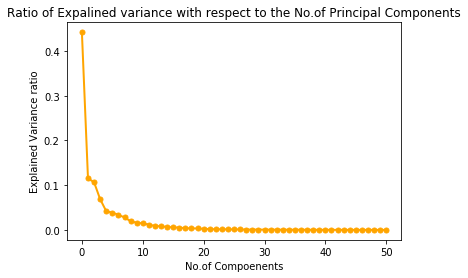

In [35]:
plt.plot(pc.explained_variance_ratio_,marker = 'o', linewidth=2, markersize=5,color = 'orange')
plt.xlabel("No.of Compoenents")
plt.ylabel("Explained Variance ratio")
plt.title("Ratio of Expalined variance with respect to the No.of Principal Components")

In [36]:
variance = 0
num_components = 0
for i in pc.explained_variance_ratio_:
    variance += i
    num_components += 1
    if variance >= 0.95:
        break;

pca = decomposition.PCA(n_components = num_components)
pc = pca.fit(Full_data_train_norm)
Full_data_train = pd.DataFrame(pc.transform(Full_data_train_norm))
Full_data_test = pd.DataFrame(pc.transform(Full_data_test_norm))

### Training the Machine Learning Models

### Prediction Algorithms:
###### Random Forest Regression
###### Nearest Neighbour Regression
###### Gradient Descent Regression
###### Ridge Regression

Since our goal is to predict the Relevancy scores which is continuous numerical attribute, Regression Models are required to train for the Predictions. In this project we want to analyze the results by training the models with Regression Algorithms like Random Forest, Nearest Neighbors, Ridge Regression and Gradient Boosting. Optimal parameter configuration is determined for all of these models by Hyper parameter tuning. The best algorithm low test RMSE value will then be fed to Ensemble approach to determine the optimal number estimators.

In [37]:
from sklearn.metrics import make_scorer
def my_custom_loss_func(Actual_values,predictions): 
    mse = mean_squared_error(Actual_values,predictions)
    return ((-1*np.sqrt(mse)))
rmse = make_scorer(my_custom_loss_func, greater_is_better=False)

Grid search CV is used for Hyper parameter tuning and in the above tab a Custom loss function is defined for computing the error metric in Grid search.

In [38]:
def get_clf_report(classifier,param,num_folds):
    clf = GridSearchCV(classifier,param,cv=num_folds,scoring=rmse)
    clf.fit(Full_data_train,home_depot_train.relevance)
    parameter_tuned = list((param[0]).keys())[0]
    clf_report=pd.DataFrame({parameter_tuned:clf.cv_results_['param_'+parameter_tuned],"Train_RMSE":clf.cv_results_['mean_train_score'],"Test_RMSE":clf.cv_results_['mean_test_score']})
    return clf_report

#### Random Forest Regressor

In [39]:
def DT_get_clfreport(clf,param_config):
    trees=np.array([[0,0,0,0]])                         # Used to store the Error rates and Parameter Config for an iteration

    kf = KFold(n_splits=10)
    for num_parent in param_config:                     # Iterating the Parameters           
        num_child=num_parent/2
        rmse_train = []
        rmse_test = []
        for train,test in kf.split(Full_data_train,home_depot_train.relevance):
            clf.set_params(**{"min_samples_split":int(num_parent),"min_samples_leaf":int(num_child)})     
            clf.fit(Full_data_train.iloc[train,:],home_depot_train.relevance.iloc[train])
            train_pred=clf.predict(Full_data_train.iloc[train,:])       # Train data is splitted into Train and Test sets and the Model is Trained
            test_pred=clf.predict(Full_data_train.iloc[test,:])
            rf_mse_train = mean_squared_error(home_depot_train.relevance.iloc[train], train_pred)
            rf_mse_test = mean_squared_error(home_depot_train.relevance.iloc[test], test_pred)       # Calculating the RMSE Values
            rmse_train.append(np.sqrt(rf_mse_train))
            rmse_test.append(np.sqrt(rf_mse_test))
        temp=np.array([[int(num_parent),int(num_child),np.mean(rmse_train),np.mean(rmse_test)]])
        trees=np.append(trees,temp,0)
    DT_clf_report=pd.DataFrame(trees[1:,:],columns=['Min_Cases in parent','Min_Cases in Child','Train RMSE','Test RMSE'])
    return DT_clf_report


In [40]:
%%time
import math
start=round(math.sqrt(0.9*home_depot_train.shape[0]))
cases_parent=np.linspace(25,start+500,15,dtype=int)
DT_clf_report=DT_get_clfreport(RandomForestRegressor(),cases_parent)

Wall time: 14min 9s


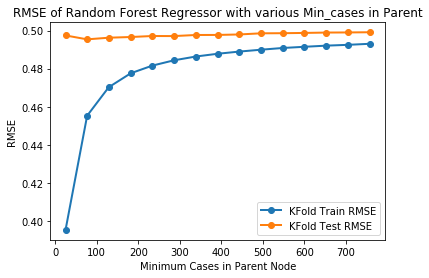

In [41]:
plt.title("RMSE of Random Forest Regressor with various Min_cases in Parent")
plt.plot(DT_clf_report["Min_Cases in parent"],DT_clf_report["Train RMSE"],marker='.',linewidth=2, markersize=12)
plt.plot(DT_clf_report["Min_Cases in parent"],DT_clf_report["Test RMSE"],marker='.',linewidth=2, markersize=12)
plt.xlabel("Minimum Cases in Parent Node")
plt.ylabel("RMSE")
plt.legend(("KFold Train RMSE","KFold Test RMSE"))

#### Gradient Boosting Regressor

In [42]:
%%time
from sklearn.ensemble import GradientBoostingRegressor

gradient_reg= GradientBoostingRegressor()
learning_rates_list = [0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.5,2.0]
param = [{'learning_rate':list(learning_rates_list)}]
gradient_report = get_clf_report(gradient_reg,param,10)

Wall time: 26min 6s


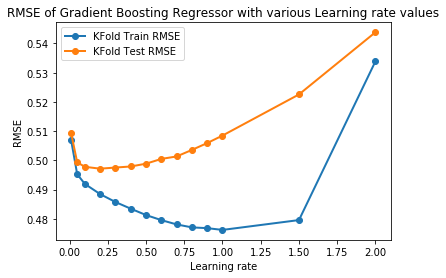

In [43]:
plt.title("RMSE of Gradient Boosting Regressor with various Learning rate values")
plt.plot(gradient_report["learning_rate"],gradient_report["Train_RMSE"],marker='.',linewidth=2, markersize=12)
plt.plot(gradient_report["learning_rate"],gradient_report["Test_RMSE"],marker='.',linewidth=2, markersize=12)
plt.xlabel("Learning rate")
plt.ylabel("RMSE")
plt.legend(("KFold Train RMSE","KFold Test RMSE"))

#### Ridge Regression

In [44]:
%%time
from sklearn.linear_model import Ridge

Ridge_reg= Ridge()
alpha_list = [0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
param = [{'alpha':list(alpha_list)}]
Ridge_report = get_clf_report(Ridge_reg,param,10)

Wall time: 3.28 s


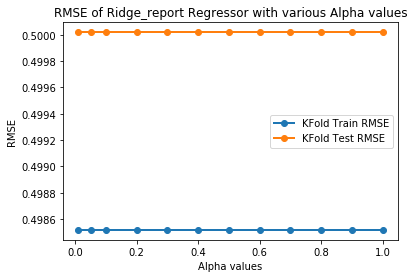

In [45]:
plt.title("RMSE of Ridge_report Regressor with various Alpha values")
plt.plot(Ridge_report["alpha"],Ridge_report["Train_RMSE"],marker='.',linewidth=2, markersize=12)
plt.plot(Ridge_report["alpha"],Ridge_report["Test_RMSE"],marker='.',linewidth=2, markersize=12)
plt.xlabel("Alpha values")
plt.ylabel("RMSE")
plt.legend(("KFold Train RMSE","KFold Test RMSE"))

#### Nearest Neighbour Regression

In [46]:
%%time
from sklearn import neighbors

KNN_reg= neighbors.KNeighborsRegressor()
neighbours_list = [15,19,21,25,29,33,37,41,45,49,53,57,61,65]
param = [{'n_neighbors':list(neighbours_list)}]
KNN_report = get_clf_report(KNN_reg,param,5)

Wall time: 49min 41s


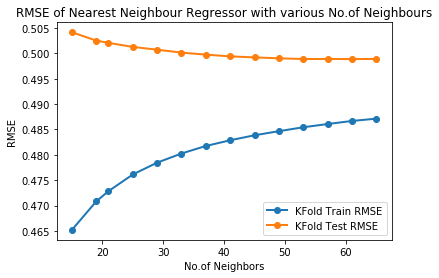

In [47]:
plt.title("RMSE of Nearest Neighbour Regressor with various No.of Neighbours")
plt.plot(KNN_report["n_neighbors"],KNN_report["Train_RMSE"],marker='.',linewidth=2, markersize=12)
plt.plot(KNN_report["n_neighbors"],KNN_report["Test_RMSE"],marker='.',linewidth=2, markersize=12)
plt.xlabel("No.of Neighbors")
plt.ylabel("RMSE")
plt.legend(("KFold Train RMSE","KFold Test RMSE"))

### Submitting the Predictions of Test Data

In [48]:
%%time
rf = RandomForestRegressor(min_samples_split=77,min_samples_leaf=38)  ## Model with Optimal no.of estimators 

rf.fit(Full_data_train, home_depot_train.relevance)

y_pred = rf.predict(Full_data_test)                     ## Predicting the Test Relevane Scores

test_predictions = pd.DataFrame({"id":home_depot_test.id,"relevance":y_pred})
test_predictions = test_predictions.set_index("id")
test_predictions.to_csv("Test_Predictions_rf_1.csv", float_format="%1.2f")           ## Submission of Test_predictions

gradient_reg= GradientBoostingRegressor(learning_rate = 0.2)  ## Model with Optimal no.of estimators 

gradient_reg.fit(Full_data_train, home_depot_train.relevance)

y_pred = gradient_reg.predict(Full_data_test)                     ## Predicting the Test Relevane Scores

test_predictions = pd.DataFrame({"id":home_depot_test.id,"relevance":y_pred})
test_predictions = test_predictions.set_index("id")
test_predictions.to_csv("Test_Predictions_gradient_1.csv", float_format="%1.2f")           ## Submission of Test_predictions

Ridge_reg= Ridge(alpha = 0.05)
Ridge_reg.fit(Full_data_train, home_depot_train.relevance)

y_pred = Ridge_reg.predict(Full_data_test)                     ## Predicting the Test Relevane Scores

test_predictions = pd.DataFrame({"id":home_depot_test.id,"relevance":y_pred})
test_predictions = test_predictions.set_index("id")
test_predictions.to_csv("Test_Predictions_Ridge_1.csv", float_format="%1.2f")           ## Submission of Test_predictions

KNN_reg= neighbors.KNeighborsRegressor(n_neighbors = 15)
KNN_reg.fit(Full_data_train, home_depot_train.relevance)

y_pred = KNN_reg.predict(Full_data_test)                     ## Predicting the Test Relevane Scores

test_predictions = pd.DataFrame({"id":home_depot_test.id,"relevance":y_pred})
test_predictions = test_predictions.set_index("id")
test_predictions.to_csv("Test_Predictions_KNN_1.csv", float_format="%1.2f")           ## Submission of Test_predictions

Wall time: 44.4 s


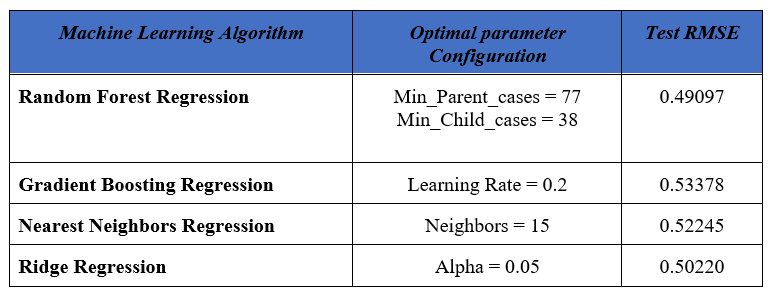

In [49]:
from IPython.display import Image
Image(filename='D:/RMSE Table.png', width=700)

By analyzing the error plots the optimal parameter configuration for every model is determined. With the Optimal parameters of each Model the Test data relevance Scores are Predicted and submitted to the Kaggle for RMSE scores. Out of all Algorithms Random Forest Regressor has the least RMSE value = 0.49097. Hence Random Forest Regressor is ensembled in the next section to further reduce the Test_RMSE value.

#### Ensembling Random Forest Regressor

In [50]:
%%time
estimators = np.linspace(1,53,14,dtype=int)
param = [{'n_estimators':list(estimators)}]
Ensemble_report = get_clf_report(RandomForestRegressor(min_samples_split=77,min_samples_leaf=38),param,5)
print(" Random Forest Regressor Performance on the data with various No.of Estimators")

 Random Forest Regressor Performance on the data with various No.of Estimators
Wall time: 16min 25s


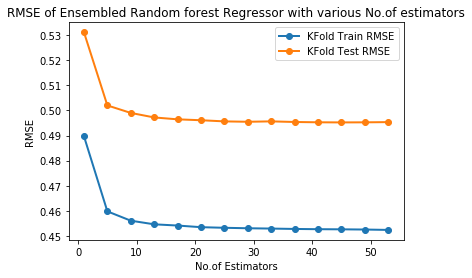

In [51]:
plt.title("RMSE of Ensembled Random forest Regressor with various No.of estimators")
plt.plot(Ensemble_report["n_estimators"],Ensemble_report["Train_RMSE"],marker='.',linewidth=2, markersize=12)
plt.plot(Ensemble_report["n_estimators"],Ensemble_report["Test_RMSE"],marker='.',linewidth=2, markersize=12)
plt.xlabel("No.of Estimators")
plt.ylabel("RMSE")
plt.legend(("KFold Train RMSE","KFold Test RMSE"))

### Final Predictions of the Test data with Ensemble Random Forest Regessor

In [52]:
rf = RandomForestRegressor(n_estimators=21,min_samples_split=77,min_samples_leaf=38)  ## Model with Optimal no.of estimators 

rf.fit(Full_data_train, home_depot_train.relevance)

y_pred = rf.predict(Full_data_test)                     ## Predicting the Test Relevane Scores

test_predictions = pd.DataFrame({"id":home_depot_test.id,"relevance":y_pred})
test_predictions = test_predictions.set_index("id")
test_predictions.to_csv("Test_Predictions_final.csv", float_format="%1.2f")           ## Final Submission of Test_predictions

The Final predictions are computed with 13 estimators for Random Forest Regressor. With this Ensembled model the Test_RMSE is further decreased to 0.48614.